# Learning Curve Analysis 
## Used in "Target templates and the time course of distractor location learning"
### A. A. Hanne, J. Tünnermann & A. Schubö


This notebook provides the code for fitting a learning curve of the form

$ RT(x) = a+(s-a) \cdot (x + 1)^{-c}$

where RT is the predicted response time at block $x$, $a$ is the asymptotic RT-level at which the slope of the curve approaches zero, $s$ is the starting RT level (RT level observers have before they start learning) and $c$ is a decrease rate parameter that models how quickly the asymptote is approached.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces (this takes long) or load them from disk. You can download our traces from https://osf.io/5wcex/ and copy them in the traces/ subfolder.

### Imports:

In [1]:
import pandas as pd
import seaborn as sns
import pymc as pm
import aesara.tensor as at
import arviz as az
from matplotlib.pylab import plt
import os.path
import numpy as np
from numpy import mean
%matplotlib notebook

### Select experimental task
Decide which experimental task (feature-specific or singleton) you would like to load for fitting the learning curve

In [2]:
experiment = 'feature-specific' 
#experiment = 'singleton'

palette = {'feature-specific' : ["#a6cee3", "#1f78b4", "#999999"],
           'singleton' :  ["#b2df8a", "#33a02c", "#999999"]} 

### Load data

In [3]:
data = pd.read_csv('data/Dataset_Learning_Curve_Model.csv', sep=';', decimal=',')
data = data[data['task'] == experiment]
display(data)

,participant_number,RT,condition,block_number,task
6990,112,731,high,0,feature-specific
6991,112,1126,high,0,feature-specific
6992,112,707,high,0,feature-specific
6993,112,613,high,0,feature-specific
6994,112,1162,high,0,feature-specific
...,...,...,...,...,...
16631,119,424,distractor_absent,7,feature-specific
16632,119,530,distractor_absent,7,feature-specific
16633,119,377,distractor_absent,7,feature-specific
16634,119,593,distractor_absent,7,feature-specific


### Data preprocessing

Define arrays

In [4]:
block_number = data['block_number'].values + 1 
participant_idx, participants  = pd.factorize(data['participant_number'])
conditions = ['distractor_absent', 'low', 'high']
condition_idx = [conditions.index(e) for e in data['condition']]
n_participant_idx = len(participants)
n_condition_idx = len(conditions)

Convert response times to seconds

In [5]:
RTS = data['RT']  / 1000.0

### Define the learning curve

In [6]:
def learning_curve(s, a, x, c):
    return (a + (s - a) * (x+1) ** (-c))

### Define the models

The function below can return the learing curve model allowing for condition-dependent effects in $a$, $c$, or both.

In [7]:
def get_model(c_effects=True, a_effects=True):
    
    with pm.Model() as model:
        
        sd_mu = pm.Normal('sd_mu', -2, 1)
        s_mu = pm.Normal('s_mu',  -0.3, 0.5)        

        sd_sd = pm.HalfCauchy('sd_sd', 0.1)
        s_sd = pm.HalfCauchy('s_sd',   0.1)
       
        sd_z = pm.Normal('sd_e', 0, 1, shape=n_participant_idx)
        s_z = pm.Normal('s_e', 0, 1, shape=n_participant_idx)

        sd = pm.Deterministic('sd', pm.math.exp(sd_mu + sd_z * sd_sd))
        s = pm.Deterministic('s', pm.math.exp(s_mu + s_z * s_sd))
        
        if c_effects:
            c_mu = pm.Normal('c_mu', 1.8, 1, shape=n_condition_idx)
            c_eff_σ_dist =  pm.HalfCauchy.dist(1, shape=n_condition_idx) 
            c_col, _, c_sd = pm.LKJCholeskyCov('c_col_cov', n=n_condition_idx, eta=1, sd_dist=c_eff_σ_dist, compute_corr=True)
            c_effs_raw = pm.Normal('c_effect_raw', mu=0, sigma=1, shape=(n_participant_idx,n_condition_idx))
            c_effs = pm.Deterministic('c_effs', at.dot(c_col, c_effs_raw.T).T)
            c = pm.Deterministic('c', pm.math.exp(c_mu + c_effs))
        else:
            c_mu = pm.Normal('c_mu', 1.8, 1)
            c_sd = pm.HalfCauchy('c_sd', 0.5)
            c_z = pm.Normal('c_e', 0,1, shape=n_participant_idx)
            c = pm.Deterministic('c', pm.math.exp(at.stack([c_mu + c_sd * c_z,
                                                c_mu + c_sd * c_z, 
                                                c_mu + c_sd * c_z], axis=1)))    

        c_ind = (participant_idx, condition_idx)
        
        if a_effects:
            a_mu = pm.Normal('a_mu',  -0.5, 0.5, shape=3)
            a_eff_σ_dist = pm.HalfCauchy.dist(1, shape=3)
            a_col, _, a_sd = pm.LKJCholeskyCov('a_col_cov', n=3, eta=1, sd_dist=a_eff_σ_dist, compute_corr=True)
            a_eff_raw = pm.Normal('a_effect_raw', mu=0, sigma=1, shape=(n_participant_idx,3))
            a_eff = pm.Deterministic('a_effect', at.dot(a_col, a_eff_raw.T).T)
            a = pm.Deterministic('a', pm.math.exp(a_mu + a_eff))
        else:
            a_mu = pm.Normal('a_mu',  -0.5, 0.5)
            a_sd = pm.HalfCauchy('a_sd', 0.5)
            a_z = pm.Normal('a_e', 0,1, shape=n_participant_idx)
            a = pm.Deterministic('a', pm.math.exp(at.stack([a_mu + a_z * a_sd,
                                                a_mu + a_z * a_sd,
                                                a_mu + a_z * a_sd], axis=1)))
    
        a_ind = (participant_idx, condition_idx)

        a_group_mean = pm.Deterministic('a_group_mean', pm.math.exp(a_mu + (a_sd*a_sd) / 2.0))
        c_group_mean = pm.Deterministic('c_group_mean', pm.math.exp(c_mu + (c_sd*c_sd) / 2.0))
        s_group_mean = pm.Deterministic('s_group_mean', pm.math.exp(s_mu + (s_sd*s_sd) / 2.0))

        mean_in_block = pm.Deterministic('mean_in_block', learning_curve(s[participant_idx], a[a_ind], block_number, c[c_ind]))

        obs = pm.Normal('obs', mu=mean_in_block, sigma=sd[participant_idx], observed=RTS)
        
        # The follwoing differences are no longer used. These variables remain here for 
        # compatibility with previously saved traces in ppc sampling.
        c_diff_low_mean = pm.Deterministic('c_diff_low_mean', at.mean(c[:, 0] - c[:, 1], axis=0))
        c_diff_high_mean = pm.Deterministic('c_diff_high_mean', at.mean(c[:, 0] - c[:, 2], axis=0))
        a_diff_low_mean = pm.Deterministic('a_diff_low_mean', at.mean(a[:, 0] - a[:, 1], axis=0))
        a_diff_high_mean = pm.Deterministic('a_diff_high_mean', at.mean(a[:, 0] - a[:, 2], axis=0))
     
        return model    

### Run the models (or load samples from disk)

The cell below runs the differerent model variants and saves the traces. Alternatively, if traces already exist, they are loaded from disk for further analysis

In [8]:
model_ceff_aeff = get_model(a_effects=True, c_effects=True)
model_ceff_only = get_model(a_effects=False, c_effects=True)
model_aeff_only = get_model(a_effects=True, c_effects=False)
model_noeff = get_model(a_effects=False, c_effects=False)


models = {
    'model_ceff_aeff'          :  None,
    'model_ceff_only'          :  None,
    'model_aeff_only'          :  None, 
    'model_noeff'              :  None, 
}

samples = 4000 
tune = 1000

for model in models:
        fn = 'traces/trace_'+model+'_'+experiment+'.nc'
        if not os.path.isfile(fn):
            print('Fitting and storing ' + model+'_'+experiment)
            models[model] = pm.sample(samples, model=locals()[model], tune=tune, target_accept=0.90, init='adapt_diag') # ta = 90
            models[model].to_netcdf(fn)
        else:
            print('Loading ' +model + '_'+experiment+ ' from disk! Delete/rename the existing file if you want to fit newly instead of loading')
            models[model] = az.from_netcdf(fn)

Loading model_ceff_aeff_feature-specific from disk! Delete/rename the existing file if you want to fit newly instead of loading
Loading model_ceff_only_feature-specific from disk! Delete/rename the existing file if you want to fit newly instead of loading
Loading model_aeff_only_feature-specific from disk! Delete/rename the existing file if you want to fit newly instead of loading
Loading model_noeff_feature-specific from disk! Delete/rename the existing file if you want to fit newly instead of loading


### Convergence diagnostics

Run the cell below to visually assess convergence. 
ATTENTION: Cell produces many plots

<IPython.core.display.Javascript object>


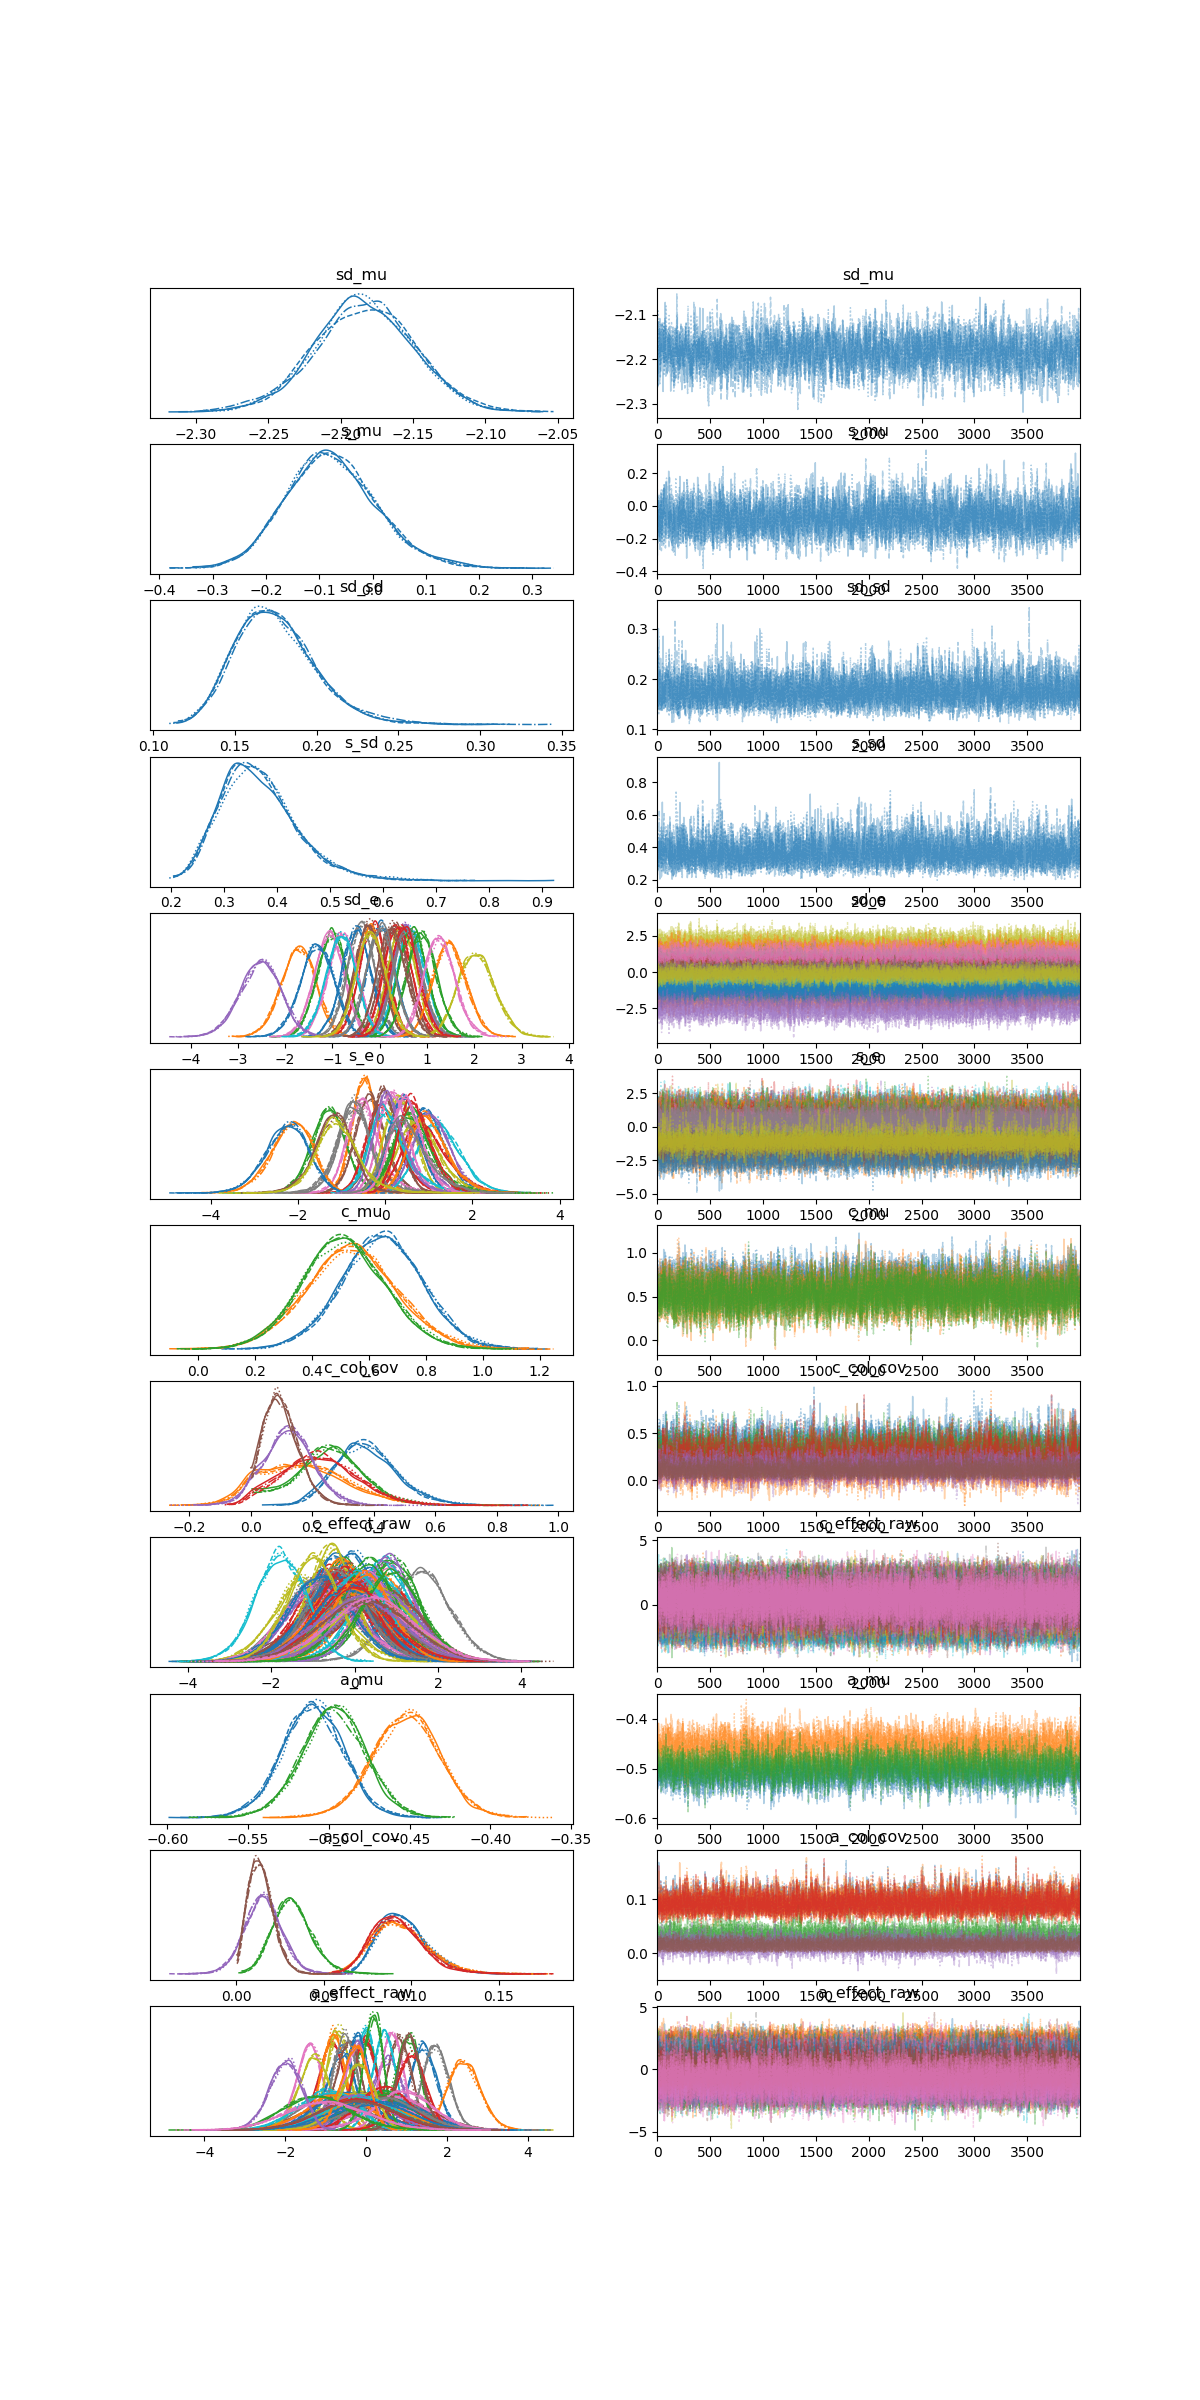

Parameter a: Correlation between baseline and low-prob:


<IPython.core.display.Javascript object>


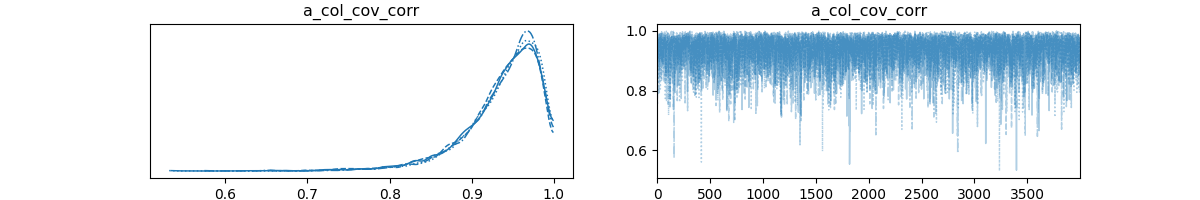

Parameter a: Correlation between baseline and high-prob:


<IPython.core.display.Javascript object>


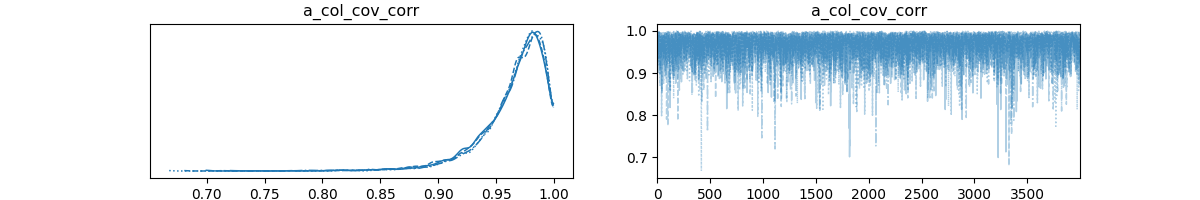

Parameter a: Correlation between  low-prob and high-prob:


<IPython.core.display.Javascript object>


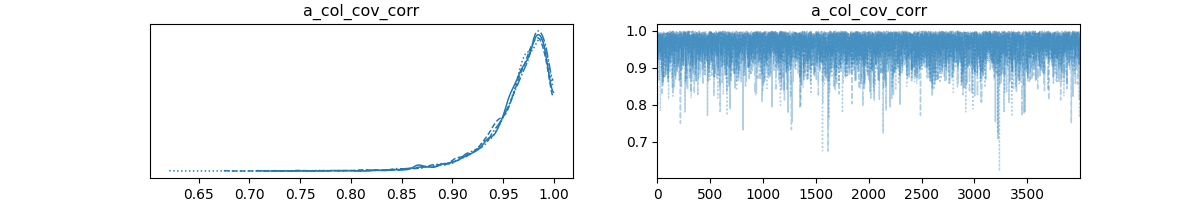

Parameter c: Correlation between baseline and low-prob:


<IPython.core.display.Javascript object>


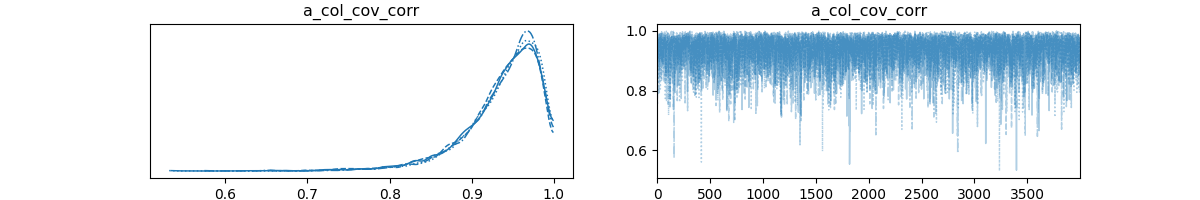

Parameter c: Correlation between baseline and high-prob:


<IPython.core.display.Javascript object>


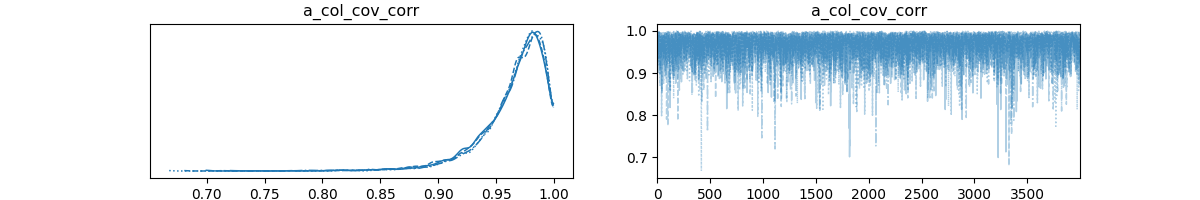

Parameter c: Correlation between  low-prob and high-prob:


<IPython.core.display.Javascript object>


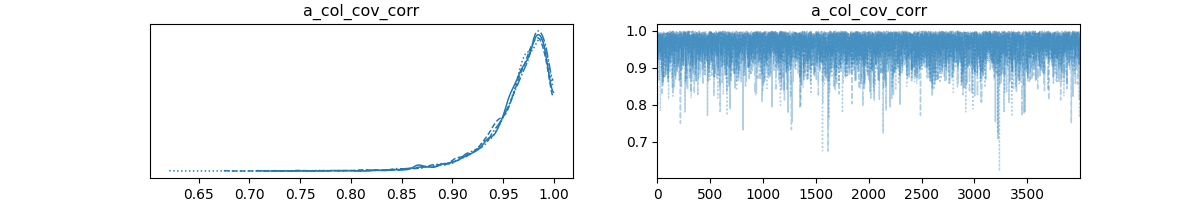

array([[<AxesSubplot:title={'center':'a_col_cov_corr'}>,
        <AxesSubplot:title={'center':'a_col_cov_corr'}>]], dtype=object)

In [9]:
# Plot traces except the LKJCholeskyCov correlation variables, which do not work directly with plot_trace
az.plot_trace(models['model_ceff_aeff'], var_names=[v.name for v in model_ceff_aeff.basic_RVs 
                                                    if 'corr' not in v.name and v.name is not 'obs'])
# Plot LKJCholeskyCov correlations:
print('Parameter a: Correlation between baseline and low-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 0,
                                                                                 'a_col_cov_corr_dim_1' : 1})
print('Parameter a: Correlation between baseline and high-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 0,
                                                                                 'a_col_cov_corr_dim_1' : 2})
print('Parameter a: Correlation between  low-prob and high-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 1,
                                                                                 'a_col_cov_corr_dim_1' : 2})

print('Parameter c: Correlation between baseline and low-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 0,
                                                                                 'a_col_cov_corr_dim_1' : 1})
print('Parameter c: Correlation between baseline and high-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 0,
                                                                                 'a_col_cov_corr_dim_1' : 2})
print('Parameter c: Correlation between  low-prob and high-prob:')
az.plot_trace(models['model_ceff_aeff'], var_names=['a_col_cov_corr'] , coords ={'a_col_cov_corr_dim_0' : 1,
                                                                                 'a_col_cov_corr_dim_1' : 2})

### Comparison of the models

Run a model comparison between the different model variants.

In [10]:
az.compare(models, ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_ceff_aeff,0,7292.025926,179.228861,0.000000,0.431688,94.314250,0.000000,False,log
model_aeff_only,1,7291.704614,151.003765,0.321312,0.404868,94.653610,6.231468,False,log
model_ceff_only,2,7278.210998,163.801287,13.814928,0.071742,95.122831,6.352218,False,log
model_noeff,3,7210.581857,121.370844,81.444070,0.091702,97.704694,16.071751,False,log


Note: The model_ceff_aeff ranks best (feature task) or second best with only a slight distance to model_aeff_only. Consequently we use model_ceff_aeff, which allows for effects in $a$ and $c$ parameters in all subsequent analysis.

### Plot learning curves

Sample form the posterior predictive and create aggregated curves.
This may take a while

<IPython.core.display.Javascript object>


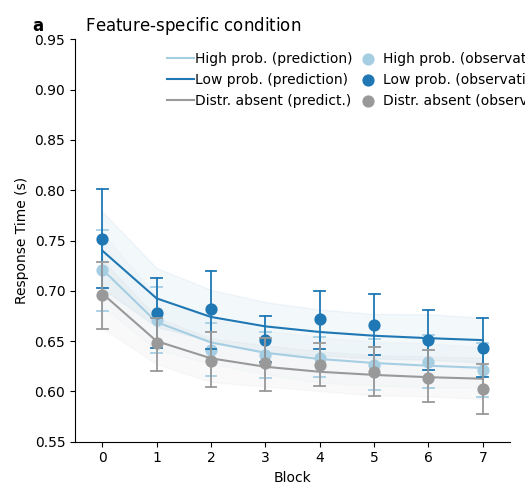

In [11]:
# Sample from the posterior predictive distribution

trace = models['model_ceff_aeff']
with model_ceff_aeff:
    ppc_samples = pm.sample_posterior_predictive(trace, keep_size=True)


data['prediction_mean'] =  mean(ppc_samples.posterior_predictive['obs'], axis=(0,1))
data['condition_pred'] = data['condition'] + ' (prediction)'
data['condition_obs'] = data['condition'] + ' (observation)'
data['condition_pred'] = data['condition'] + ' (prediction)'
#data = data.sort_values('condition')


data_p = data.groupby(['participant_number', 'block_number', 'condition','condition_obs','condition_pred']).mean().reset_index()
data_p['RT_s'] = data_p['RT'] / 1000.0

fig, ax = plt.subplots(figsize=(5.25,5))
 
sns.set_palette(palette[experiment], 3)

# Rename columns for plotting:
data_p = data_p.rename(columns=
{
  'block_number'      : 'Block',
  'RT_s'              : 'Response Time (s)'
})

# Rename values
data_p = data_p.replace({                       
  'high (prediction)' : 'High prob. (prediction)',
  'low (prediction)'  : 'Low prob. (prediction)',
  'distractor_absent (prediction)' : 'Distr. absent (predict.)',
  'high (observation)' : 'High prob. (observation)',
  'low (observation)'  : 'Low prob. (observation)',
  'distractor_absent (observation)' : 'Distr. absent (observation)'
})

# Plot
sns.lineplot(data=data_p, x='Block', y='prediction_mean', hue='condition_pred',
             hue_order=['High prob. (prediction)', 'Low prob. (prediction)', 'Distr. absent (predict.)'],
             ax=ax, err_kws={'alpha' : 0.05})
sns.pointplot(data=data_p, x='Block', y='Response Time (s)', hue='condition_obs',
              hue_order=['High prob. (observation)', 'Low prob. (observation)', 'Distr. absent (observation)'],
              join=False, ax=ax, errwidth=1.3, capsize=0.2)
sns.despine()

plt.ylim(0.55, 0.95)
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()
#fig.legend(h,l, ncol=2, bbox_to_anchor=(0.52, 0.84), loc='center', frameon=False,
#           handletextpad=0.07, columnspacing=0.1)
fig.legend(h,l, ncol=2, bbox_to_anchor=(0.7,0.84), loc='center', frameon=False, handletextpad=0.07, columnspacing=0.1)
plt.title(r'${\bf{a}}$        ' + experiment.capitalize() + ' condition', y=1 , x=-0.1, loc='left')
plt.tight_layout()
plt.savefig(experiment + '_postpredcurves.svg')

### Plot parameter estimates

The cell below plots the group-level estimates of the main parameters

<IPython.core.display.Javascript object>


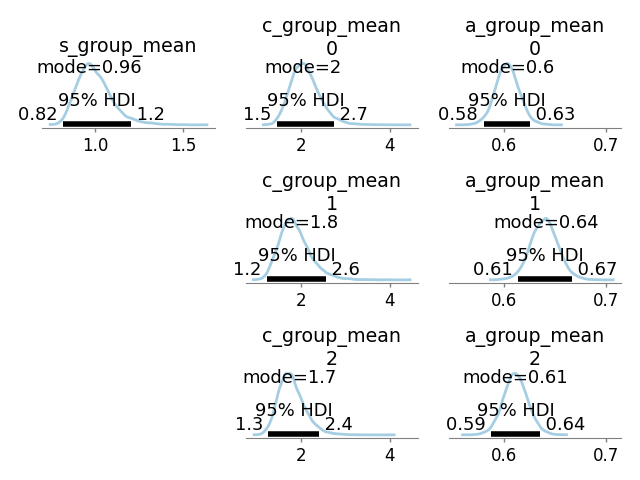

In [16]:
f, ax = plt.subplots(3,3, sharex='col')
with model_ceff_aeff: 
    az.plot_posterior(models['model_ceff_aeff'], var_names=["s_group_mean"],
                    hdi_prob=0.95, show=True, ax=ax[:,0], point_estimate='mode', 
                    textsize=12, linewidth=2, color=palette[experiment][0])
    az.plot_posterior(models['model_ceff_aeff'], var_names=["c_group_mean"],
                    hdi_prob=0.95, show=True, ax=ax[:,1], point_estimate='mode', 
                      textsize=12, linewidth=2, color=palette[experiment][0])
    az.plot_posterior(models['model_ceff_aeff'], var_names=["a_group_mean"],
                    hdi_prob=0.95, show=True, ax=ax[:,2], point_estimate='mode',
                      textsize=12, linewidth=2, color=palette[experiment][0])
    ax[1, 0].axis('off')
    ax[2, 0].axis('off')
    plt.tight_layout()
    plt.savefig(experiment + 'group_posteriors.svg')

### Plot parameters relative to distractor-absent 

<IPython.core.display.Javascript object>


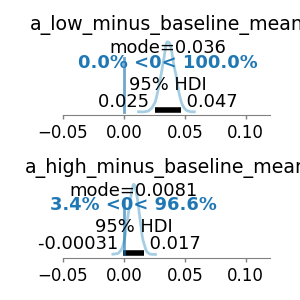

<IPython.core.display.Javascript object>


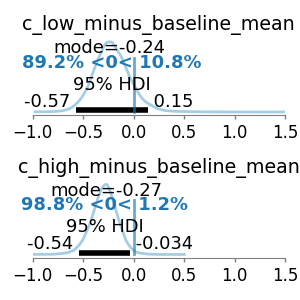

In [17]:
posterior = models['model_ceff_aeff'].posterior
posterior['a_high_minus_baseline_mean'] = (posterior.a.sel({'a_dim_1' : 2}) - posterior.a.sel({'a_dim_1' : 0}))\
                                     .mean(dim=['a_dim_0'])
posterior['a_low_minus_baseline_mean'] = (posterior.a.sel({'a_dim_1' : 1}) - posterior.a.sel({'a_dim_1' : 0}))\
                                     .mean(dim=['a_dim_0'])

posterior['c_high_minus_baseline_mean'] = (posterior.c.sel({'c_dim_1' : 2}) - posterior.c.sel({'c_dim_1' : 0}))\
                                     .mean(dim=['c_dim_0'])
posterior['c_low_minus_baseline_mean'] = (posterior.c.sel({'c_dim_1' : 1}) - posterior.c.sel({'c_dim_1' : 0}))\
                                     .mean(dim=['c_dim_0'])

f, ax = plt.subplots(2,1, figsize=(3,3), sharex=True)
az.plot_posterior(models['model_ceff_aeff'],
                  var_names=['a_low_minus_baseline_mean', 'a_high_minus_baseline_mean'], point_estimate='mode',
                  hdi_prob=0.95, ref_val=0, show=True, textsize=12, linewidth=2, ax=ax,
                  color=palette[experiment][0])

plt.tight_layout()
plt.xlim(-0.05, 0.12)
plt.savefig(experiment + '_difference_a_baseline.svg')

f, ax = plt.subplots(2,1, figsize=(3,3), sharex=True)
az.plot_posterior(models['model_ceff_aeff'],
                  var_names=['c_low_minus_baseline_mean', 'c_high_minus_baseline_mean'], point_estimate='mode',
                  hdi_prob=0.95, ref_val=0, show=True, textsize=12, linewidth=2, ax=ax,
                  color=palette[experiment][0])
plt.tight_layout()
plt.xlim(-1, 1.5)
plt.savefig(experiment + '_difference_c_baseline.svg')

### Visualizing the priors and posteriors

Since the priors for the group-level estimates are log-normal, it is difficult to assess how much information is encoded in them. The code below plots the priors and posteriors mean of these distributions on the data scale. As can be seen, the priors are essentially flat over the relevant range.

<IPython.core.display.Javascript object>


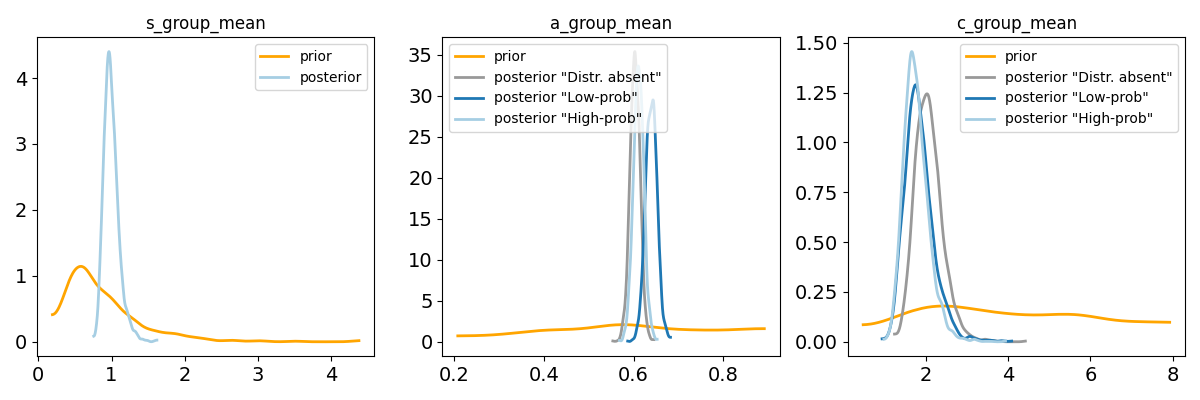

In [18]:
with model_ceff_aeff:
    prior = pm.sample_prior_predictive()
    models['model_ceff_aeff'].extend(prior)

f, axs = plt.subplots(1,3, figsize=(12,4))
    
s_group_mean_prior = models['model_ceff_aeff'].prior['s_group_mean'][0]
az.plot_dist(s_group_mean_prior[s_group_mean_prior < 5], color='orange', ax=axs[0], plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(models['model_ceff_aeff'].posterior['s_group_mean'][0],  ax=axs[0], plot_kwargs={'lw':2, 'label':'posterior'})    
axs[0].set_title('s_group_mean')
axs[0].legend()


a_group_mean_prior = models['model_ceff_aeff'].prior['a_group_mean'][0,:,0]
az.plot_dist(a_group_mean_prior[a_group_mean_prior < 0.9], color='orange', ax=axs[1],
             plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(models['model_ceff_aeff'].posterior['a_group_mean'][0,:,0], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "Distr. absent"'}, color=palette[experiment][2])    
az.plot_dist(models['model_ceff_aeff'].posterior['a_group_mean'][0,:,1], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "Low-prob"'}, color=palette[experiment][1])    
az.plot_dist(models['model_ceff_aeff'].posterior['a_group_mean'][0,:,2], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "High-prob"'}, color=palette[experiment][0])    
axs[1].set_title('a_group_mean')
axs[1].legend(loc='upper left')

c_group_mean_prior = models['model_ceff_aeff'].prior['c_group_mean'][0,:,0]
az.plot_dist(c_group_mean_prior[c_group_mean_prior < 8], color='orange', ax=axs[2],
             plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(models['model_ceff_aeff'].posterior['c_group_mean'][0,:,0], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "Distr. absent"'}, color=palette[experiment][2])    
az.plot_dist(models['model_ceff_aeff'].posterior['c_group_mean'][0,:,1], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "Low-prob"'}, color=palette[experiment][1])    
az.plot_dist(models['model_ceff_aeff'].posterior['c_group_mean'][0,:,2], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "High-prob"'}, color=palette[experiment][0])    
axs[2].set_title('c_group_mean')
axs[2].legend(loc='upper right')


plt.tight_layout()
plt.savefig(experiment + 'priors_posteriors.svg')

### Plot differences between task conditions
Note, that traces for both task conditions (feature-specific and singleton) should be saved before calculating. The traces are loaded in the first step.

<IPython.core.display.Javascript object>


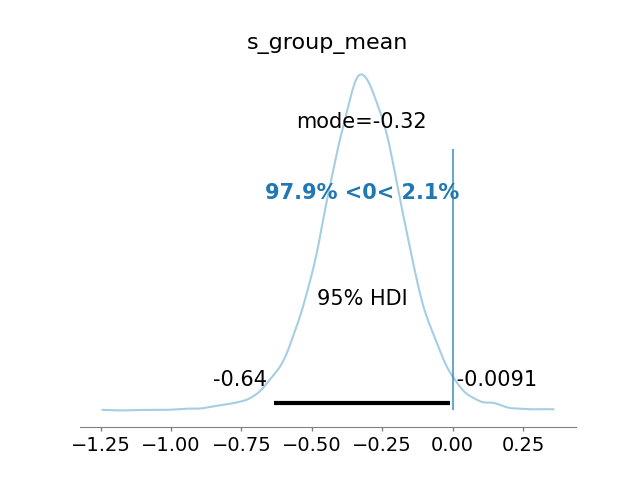

<IPython.core.display.Javascript object>


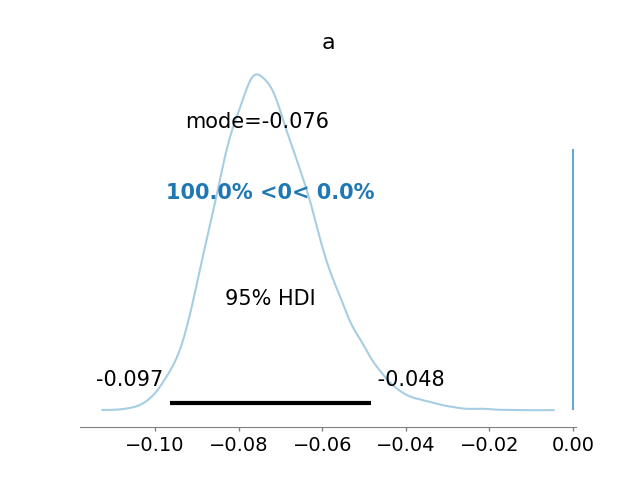

In [20]:
trace_ceff_aeff_singleton = az.from_netcdf('traces/trace_model_ceff_aeff_singleton.nc')
trace_ceff_aeff_feature =  az.from_netcdf('traces/trace_model_ceff_aeff_feature-specific.nc')

s_group_mean_between = (trace_ceff_aeff_feature.posterior.s_group_mean - trace_ceff_aeff_singleton.posterior.s_group_mean)
az.plot_posterior(s_group_mean_between, point_estimate='mode', hdi_prob=0.95,  ref_val=0)

a_baseline_between = (trace_ceff_aeff_feature.posterior.a.sel({'a_dim_1' : 0})
                  - trace_ceff_aeff_singleton.posterior.a.sel({'a_dim_1' : 0})).mean(dim=['a_dim_0'])
az.plot_posterior(a_baseline_between, point_estimate='mode', hdi_prob=0.95,  ref_val=0)

plt.savefig('Differences_between.svg')